<a href="https://colab.research.google.com/github/aleexxy/CME241-2024W/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stanford CME 241 (Winter 2024) - Assignment 2

**Due: Jan 22 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Please solve questions 1 and 2, and choose one of questions 3 or 4.**
- Questions 1 and 2 of this homework focus on Markov Processes (MP and MRP) that were taught in class in the second week and are covered in Chapter 3 of the book.
- Questions 3 and 4 cover Markov Decision Processes that will be taught in the third week and are covered in Chapter 4 of the book.
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):*

https://github.com/my-username/my-repo/assignment-file-name.ipynb

***Group Members:***

Handi Zhao,

Sylvia Sun,

Zhengji Yang

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random, itertools

from rl.distribution import Categorical, Distribution, FiniteDistribution, SampledDistribution
from rl.markov_process import FiniteMarkovProcess, FiniteMarkovRewardProcess, NonTerminal, State
from typing import Mapping, Tuple, Optional

## Question 1
In the classic childhood game of Snakes and Ladders, all players start to the left of square 1 (call this position 0) and roll a 6-sided die to represent the number of squares they can move forward. The goal is to reach square 100 as quickly as possible. Landing on the bottom rung of a ladder allows for an automatic free-pass to climb, e.g. square 4 sends you directly to 14; whereas landing on a snake's head forces one to slide all the way to the tail, e.g. square 34 sends you to 6. Note, this game can be viewed as a Markov Process, where the outcome is only depedent on the current state and not the prior trajectory. In this question, we will ask you to both formally describe the Markov Process that describes this game, followed by coding up a version of the game to get familiar with the RL-book libraries.

![2_snakes_and_ladders.png](attachment:2_snakes_and_ladders.png)

### Part a
Formalize the state space of the Snakes and Ladders game.

The states in this problem are all possible positions on the board.
S = {1, 2, ..., 100}, where S = 1 is the initial state, and S = 100 is the terminal state.

### Part b
Write out the structure of the transition probabilities. Feel free to abbreviate all squares that do not have a snake or ladder.

For regular squares (not at the head of the snake or at the bottom of the ladder) <br>
P(s'|s) = 1/6 if s + a <= 100 <br>
P(s'|s) = 0 otherwise<br>
<br>
For squares at the bottom of the ladder:<br>
P(s'=top|s=bottom) = 1<br>

For squares at the head of the snakes:<br>
P(s'=tail|s=head) = 1

### Part c
Code up a `transition_map: Transition[S]` data structure to represent the transition probabilities of the Snakes and Ladders Markov Process so you can model the game as an instance of `FiniteMarkovProcess`. Use the `traces` method to create sampling traces.

In [ ]:
snake_head = {32: 10, 36: 6, 48: 26, 63: 18, 88: 24, 95: 56, 97: 78}
ladder_bot = {1: 38, 4: 14, 8: 30, 21: 42, 28: 76, 50: 67, 71: 92, 80: 99}

def get_next_states(S):
    next_states = []
    if S in snake_head.keys():
        next_states.append(snake_head[S])
    elif S in ladder_bot.keys():
        next_states.append(ladder_bot[S])
    else:
        for i in range(1, 7):
            if S + i <= 100:
                next_states.append(S + i)
            else:
                break
    return next_states

#get_next_states(2)

In [ ]:
def get_categorical_dict(S, next_states):
    categorical_dict = {}
    #next_states = get_next_states(1)
    if len(next_states) == 1:
        categorical_dict[next_states[0]] = 1
    else:
        for key in next_states:
            categorical_dict[key] = 1/len(next_states)
    return categorical_dict

In [ ]:
def snake_ladder():
    transition_map = {}

    for i in range(1, 100):
        transition_map[i] = Categorical(get_categorical_dict(i, get_next_states(i)))

    finiteMarkovProcess = FiniteMarkovProcess(transition_map)
    init_dist = {NonTerminal(1): 1}
    init_dist = Categorical(init_dist)

    traces = finiteMarkovProcess.traces(init_dist)
    return traces

### Part d
Plot the sample traces and a graph of the distribution of time steps to finish the game.

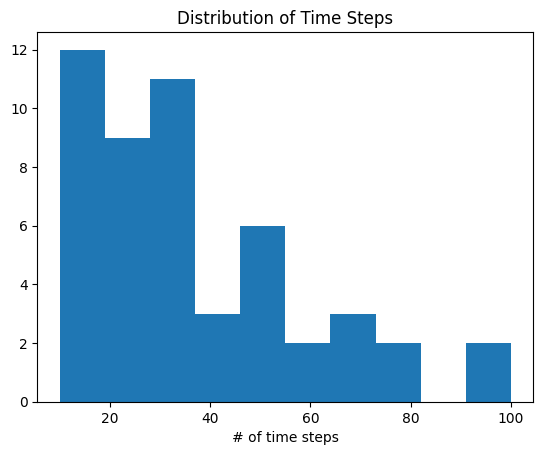

In [ ]:
traces = snake_ladder()
n_timestep = []
sample_traces = []
for sim in itertools.islice(traces, 50):
    n = 0
    trace = []
    for s in itertools.islice(sim, 100):
        n += 1
        trace.append(s.state)
    n_timestep.append(n)
    sample_traces.append(trace)

plt.hist(n_timestep)
plt.xlabel('# of time steps')
plt.title('Distribution of Time Steps')
plt.show()

Text(0.5, 1.0, 'Sample Traces')

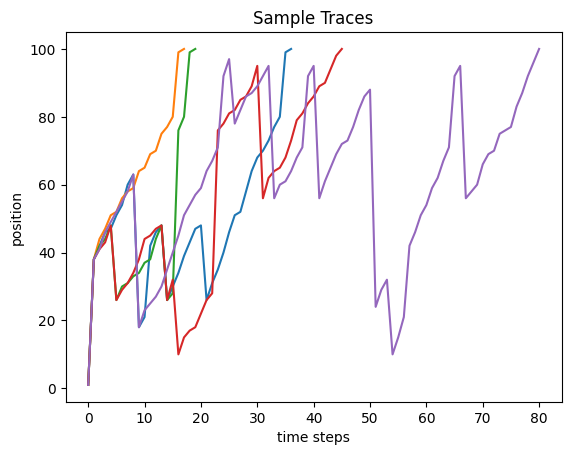

In [ ]:
for i in range(5):
    plt.plot(range(len(sample_traces[i])), sample_traces[i], color=plt.cm.tab10.colors[i])

plt.xlabel('time steps')
plt.ylabel('position')
plt.title('Sample Traces')

### Part e
For the Snakes and Ladders game, calculate the expected number of rolls to finish the game. Hint: in order to calculate this, extend the Snakes and Ladders `FiniteMarkovProcess` to an appropriate `FiniteMarkovRewardProcess` instance. What should be the Rewards model in this MRP so you can use one of the methods in the `FiniteMarkovRewardProcess` class to determine the expected number of dice rolls to finish the game?

In [ ]:
def get_transition_reward_map():
    d = {}

    def get_reward_dict(S, next_states):
        categorical_dict = {}
        if len(next_states) == 1:
            categorical_dict[(next_states[0], 1)] = 1
        else:
            for key in next_states:
                categorical_dict[(key, 1)] = 1/len(next_states)
        return categorical_dict

    for i in range(1, 100):
        d[i] = Categorical(get_reward_dict(i, get_next_states(i)))

    return d

In [ ]:
finiteMarkovRewardProcess = FiniteMarkovRewardProcess(get_transition_reward_map())
init_dist = {NonTerminal(1): 1}
init_dist = Categorical(init_dist)

finiteMarkovRewardProcess.display_value_function(gamma=1)

{NonTerminal(state=1): 34.505,
 NonTerminal(state=2): 40.535,
 NonTerminal(state=3): 40.27,
 NonTerminal(state=4): 38.362,
 NonTerminal(state=5): 39.959,
 NonTerminal(state=6): 39.651,
 NonTerminal(state=7): 39.353,
 NonTerminal(state=8): 39.614,
 NonTerminal(state=9): 38.681,
 NonTerminal(state=10): 38.375,
 NonTerminal(state=11): 38.078,
 NonTerminal(state=12): 37.806,
 NonTerminal(state=13): 37.565,
 NonTerminal(state=14): 37.362,
 NonTerminal(state=15): 36.901,
 NonTerminal(state=16): 36.534,
 NonTerminal(state=17): 36.3,
 NonTerminal(state=18): 36.175,
 NonTerminal(state=19): 36.119,
 NonTerminal(state=20): 36.145,
 NonTerminal(state=21): 34.134,
 NonTerminal(state=22): 34.331,
 NonTerminal(state=23): 34.895,
 NonTerminal(state=24): 35.426,
 NonTerminal(state=25): 35.786,
 NonTerminal(state=26): 36.298,
 NonTerminal(state=27): 36.315,
 NonTerminal(state=28): 21.269,
 NonTerminal(state=29): 38.274,
 NonTerminal(state=30): 38.614,
 NonTerminal(state=31): 37.943,
 NonTerminal(state=3

## Question 2
Consider the problem of a frog jumping across a river with $n=9$ lilypads. The frog at every time step will randomly jump to a position in front of it (e.g. at the starting step, the frog will jump with $\frac{1}{10}$ probability to each of the lilypads or $\frac{1}{10}$ to the other side of the river). A diagram of the frog jumping problem is below.

![2_jumping.png](attachment:2_jumping.png)

### Part a
Formalize the states of the jumping frog problem as well as the structure of the transition probabilites.

Denote state 0 to be the start, state 1,...,n to be lilypads, state n+1 to be the end.
The transition probabilities are as follows:

$$
P_{ij} = \begin{cases}
0 & \text{if } i > j, \\
0 & \text{for } i = j, i = 0,1,\ldots,n, \\
1 & \text{for } i = j = n+1, \\
\frac{1}{n+1-i} & \text{for } j > i.
\end{cases}
$$


$$
P = \begin{bmatrix}
0 & \frac{1}{n+1} & \frac{1}{n+1} & \cdots & \frac{1}{n+1} & \frac{1}{n+1} & \frac{1}{n+1} \\
0 & 0 & \frac{1}{n} & \cdots & \frac{1}{n} & \frac{1}{n} & \frac{1}{n} \\
0 & 0 & 0 & \ddots & \frac{1}{n-1} & \frac{1}{n-1} & \frac{1}{n-1} \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & 0 & \frac{1}{2} & \frac{1}{2} \\
0 & 0 & 0 & \cdots & 0 & 0 & 1 \\
0 & 0 & 0 & \cdots & 0 & 0 & 1 \\
\end{bmatrix}_{(n+2) \times (n+2)}
$$


### Part b
Compute the expected number of steps that it would take for the frog to reach the other side.


Let E_{i} be the expected number of steps that it would take for the frog to reach the space that is i steps from current place.

For n lilypads, there will be n+1 steps for the frog to reach the end from the start, so we need to get E_{n+1}:

$$
E_1 = 1,
$$

$$
E_2 = 1 + \frac{E_1}{2},
$$

$$
\vdots
$$

$$
E_n = 1 + \frac{\sum_{k=1}^{n-1} E_k}{n},
$$

$$
E_{n+1} = 1 + \frac{\sum_{k=1}^{n} E_k}{n+1}.
$$

By calculation, the summation of reciprocals is:

$$
E_n = 1 + \frac{1}{2} + \frac{1}{3} + \dots + \frac{1}{n}
$$

So for \( n = 9 \), the expected number of steps \( E_{10} \) or \( E_{n+1} \) is:

$$
E_{10} = E_{n+1} = 1 + \frac{1}{2} + \frac{1}{3} + \dots + \frac{1}{10} = \sum_{k=1}^{10} \frac{1}{k}
$$



### Part c
Provide a closed form solution for the expected number of steps / jumps to cross the river for arbitrary $n$. A formal proof is not required.

$$ \sum_{k=1}^{n+1} \frac{1}{k} $$

## Question 3
Consider an MDP with an infinite set of states $\mathcal{S} = \{1,2,3,\ldots \}$. The start state is $s=1$. Each state $s$ allows a continuous set of actions $a \in [0,1]$. The transition probabilities are given by: $$\mathbb{P}[s+1 \mid s, a] = a, \mathbb{P}[s \mid s, a] = 1 - a \text{ for all } s \in \mathcal{S} \text{ for all } a \in [0,1]$$
For all states $s \in \mathcal{S}$ and actions $a \in [0,1]$, transitioning from $s$ to $s+1$ results in a reward of $1-a$ and transitioning from $s$ to $s$ results in a reward of $1+a$. The discount factor $\gamma=0.5$.

### Part a
Using the MDP Bellman Optimality Equation, calculate the Optimal Value Function $V^*(s)$ for all $s \in \mathcal{S}$

According to the MDP Bellman Optimality Equation, we have

\begin{align}
V^*(s) & = max_{a} \sum_{s'} \mathbb{P}(s'|s, a) (R(s,s') + \gamma V^*(s')) \\
       & = max_{a}\,\, a * ((1 - a) + 0.5 V^*(s+1)) + (1 - a) * ((1 + a) + 0.5 V^*(s)) \\
       & = max_{a}\,\, 1 + a - 2a^2 + 0.5a * V^*(s+1) + 0.5 (1-a) * V^*(s) \\
       & = max_{a}\,\,  -2 a^2 + (1 + 0.5V^*(s+1) - 0.5V^*(s)) a + 1 + 0.5 V^*(s) \\
       & = (1 + 0.5V^*(s+1) - 0.5V^*(s))^2/8 + 1 + 0.5 V^*(s) \\
\end{align}

Due to the stationary property, $V^*(s) = V^*(s+1)$, hence  
\begin{align}
V^*(s) & = (1 + 0.5V^*(s+1) - 0.5V^*(s))^2/4 + 2 \\
       & = 2.25
\end{align}


### Part b
Calculate an Optimal Deterministic Policy $\pi^*(s)$ for all $s \in \mathcal{S}$

Let $\pi^*(s) = 1/4$ for any s, then
\begin{align}
V^{\pi^*}(s) & = 1/4 * (3/4 + 0.5 * V^{\pi^*}(s+1)) + 3/4 * (5/4 + 0.5 * V^{\pi^*}(s) ) \\
             & = 9/8 + 1/8 * V^{\pi^*}(s+1) + 3/8 * V^{\pi^*}(s)
\end{align}

According to the stationary property, $V^{\pi^*}(s+1) = V^{\pi^*}(s)$, hence
$$ V^{\pi^*}(s) = 9/8 * 2 = 2.25 = V^*(s).$$

Hence $V^{\pi^*}$ is optimal, $\pi^*$ is the optimal deterministic policy.

## Question 4
Consider again the problem of a frog jumping across a river with $n-1$ lilypads, labeled $1, \dots, n-1$, with the two riverbanks labeled positions $0$ and $n$. At each time step, the frog who is at lilypad $i$ has two options:
- (Strategy A) The frog moves to lilypad $i-1$  with probability $\frac{i}{n}$ and moves to lilypad $i+1$ otherwise.
- (Strategy B) The frog moves to arbitrary position from $0,\dots,n$ with equal probability.

The frog now starts on a random lilypad. A snake lives on one end of the river (say the snake lives at 0) and will eat the frog if it lands on this side of the river. The frog can escape by landing the other side of the river (i.e. position $n$). What should the frog's strategy be when on each of the lilypads $1, 2, \ldots, n-1$, in order to maximize the probability of escaping the pond (reaching $n$ before reaching $0$)? Although there are more than one ways of solving this problem, we would like to solve it by modeling it as an MDP and identifying the Optimal Policy.

Note: Sorry for all the frog jumping questions. These games are an easy way to understand Markov Processes, without having to build out too much detail of a financial simulation. Questions will be more related to finance over time.

### Part a
Express with clear mathematical notation the state space, the action space, transition function, and rewards function of an MDP so that the frog-escape problem would be solved by arriving at the Optimal Value Function (and hence, the Optimal Policy) of the MDP.

### Part b
Write code to model this MDP as an instance of the `FiniteMarkovDecisionProcess` class. We have learnt that there exists an optimal deterministic policy, and there are $2^{n-1}$ possible deterministic policies for this problem. Write code to create each of these $2^{n-1}$ deterministic policies (as instances of `FinitePolicy` class), create a policy-implied Finite MRP for each of these deterministic policies (using the `apply_finite_policy` method of `FiniteMarkovDecisionProcess` class), and evaluate the Value Function for each of those implied Finite MRPs (using the `get_value_function_vec` method of `FiniteMarkovRewardProcess` class). This should gives you the Optimal Value Function and the Optimal Deterministic Policy.

### Part c
Plot a graph of the Optimal Escape-Probability and of the associated strategies, as a function of the states of this MDP, for $n=3, n=6$ and $n=9$. By looking at the results on this graph, what pattern do you observe for the optimal policy as you vary $n$ from 3 to 9?

![2_frog.png](attachment:2_frog.png)